Date: 9/18/2024

In [ ]:
#!pip install scikit-learn==1.1.3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports & setting seed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

# Part I: Implement LASSO

## One Variable Lasso

We looking to solve the following problem, which is the one variable Lasso optimization problem:

$$min_b \dfrac{1}{2n} ||v - b \cdot z||^2 + \lambda |b|$$

We use the results from the derivation to find the $b$ that minimizes the problem above.


In [ ]:
def one_var_lasso(v, z, lam):
  # Input
  # v: n by 1 response vector
  # z: n by 1 reature vector
  # lam: lambda value that is > 0

  # Output
  # b_min: coefficient b that minimizes the one variable lasso optimization problem

  # Calculate a
  a = np.dot(v.T, z) / (np.sum(z**2))

  # Calculate eta
  eta = (2 * v.shape[0] * lam) / (np.sum(z**2))

  # calculate coefficient that minimizes one variable lasso optimization
  if a > (eta/2):
    b_min = a - (eta/2)
  elif abs(a) <= (eta/2):
    b_min = 0
  else:
    b_min = a + (eta/2)

  return b_min

## The CD Algorithm

In [ ]:
def MyLasso(X, y, lam_seq, maxit = 100):

    # Input
    # X: n-by-p design matrix without the intercept
    # y: n-by-1 response vector
    # lam.seq: sequence of lambda values (arranged from large to small)
    # maxit: number of updates for each lambda

    # Output
    # B: a (p+1)-by-len(lam.seq) coefficient matrix
    #    with the first row being the intercept sequence

    n, p = X.shape
    nlam = len(lam_seq)
    B = np.zeros((p+1, nlam))

    ##############################
    # YOUR CODE:
    # (1) newX = Standardizad X;
    # (2) Record the centers and scales used in (1)
    ##############################s

    center = np.mean(X, axis=0)
    scale = np.std(X, axis=0)
    newX = (X - center) / scale

    # Initilize coef vector b and residual vector r
    b = np.zeros(p)
    r = y

    # Triple nested loop
    for m in range(nlam):
        for step in range(maxit):
            for j in range(p):
                X_j = newX[:, j].reshape(-1,1)
                r = r + X_j * b[j]
                b[j] = one_var_lasso(r, X_j, lam_seq[m])
                r = r - X_j * b[j]
        B[1:, m] = b

    ##############################
    # YOUR CODE:
    # Scale back the coefficients;
    # Update the intercepts stored in B[0, ]
    ##############################

    B[1:, ] = B[1:, ] / scale.reshape(-1, 1) #Adds dim to scale so it can correctly be divided
    B[0, ] = np.mean(y)- np.dot(center, B[1:, ])


    return(B)

## Testing the Function

In [ ]:
myData = pd.read_csv("/content/Coding2_Data0.csv")
var_names = myData.columns
y = myData[['Y']].to_numpy()
X = myData.drop(['Y'], axis = 1).to_numpy()
X.shape, len(y)

((506, 13), 506)

(13,)
(13, 1)


(-8.35, -0.6499999999999999, -0.3099945835128564, 0.4997421988480512)

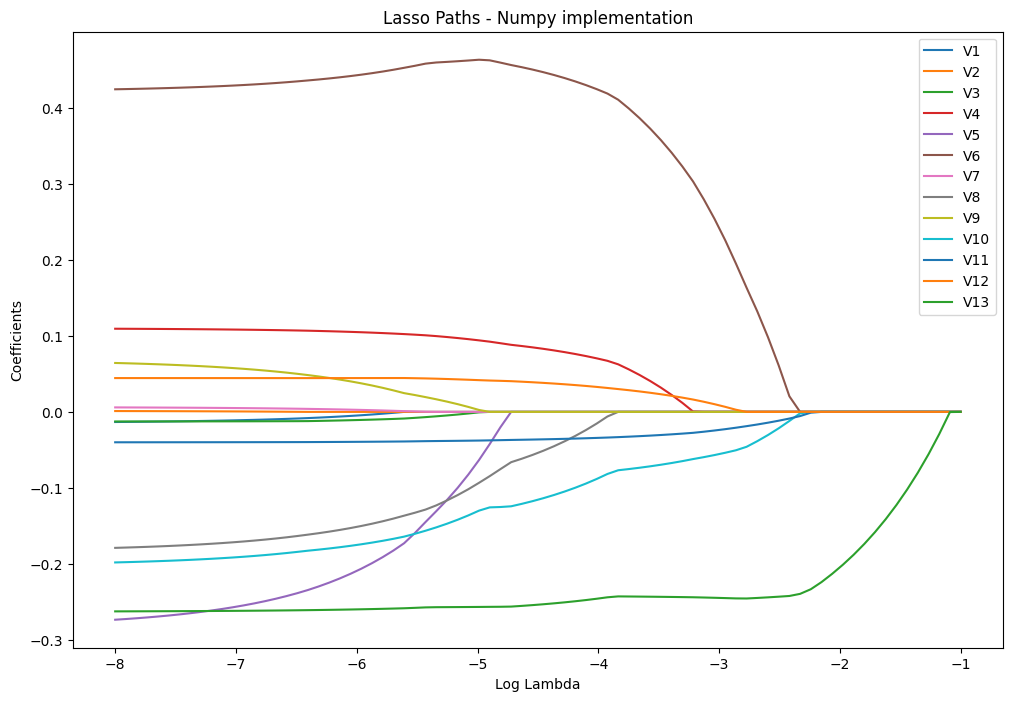

In [ ]:
log_lam_seq = np.linspace(-1, -8, num = 80)
lam_seq = np.exp(log_lam_seq)
myout = MyLasso(X, y, lam_seq, maxit = 100)
p, _ = myout.shape
plt.figure(figsize = (12,8))

for i in range(p-1):
    plt.plot(log_lam_seq, myout[i+1, :], label = var_names[i])

plt.xlabel('Log Lambda')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
plt.axis('tight')

In [ ]:
lasso_coef = pd.read_csv("/content/Coding2_lasso_coefs.csv").to_numpy()
abs(myout - lasso_coef).max()

0.004645317415919337

# Part II: Simulation Study

## Case 1

### Model implementations

In [ ]:
# Reference: https://liangfgithub.github.io/Coding/F24_Coding2_Part2_Python.html

In [ ]:
# Full model
def full(X_train, Y_train, X_test, Y_test):

  full = lm().fit(X_train, Y_train)
  error = mean_squared_error(Y_test, full.predict(X_test))

  return error

In [ ]:
# Ridge.min model
def ridge_min(X_train, Y_train, X_test, Y_test):

  # Finding the best alpha value
  ridge_alphas = np.logspace(-10, 1, 100)
  ridgecv = RidgeCV(alphas = ridge_alphas, cv = 10,
                    scoring = 'neg_mean_squared_error',
                    normalize = True)
  ridgecv.fit(X_train, Y_train)

  # Fitting Ridge Regression model with best alpha
  ridge_model = Ridge(alpha = ridgecv.alpha_, normalize = True)
  ridge_model.fit(X_train, Y_train)
  error = mean_squared_error(Y_test, ridge_model.predict(X_test))

  return error

In [ ]:
# Different Lasso models
def lasso(X_train, Y_train, X_test, Y_test, alpha_min=False,
          alpha_1se=False, lrefit=False):

  # Finding the best alpha value
  lasso_alphas = np.logspace(-10, 1, 100)
  lassocv = LassoCV(alphas = lasso_alphas, cv = 10,
                    normalize = True)
  lassocv.fit(X_train, Y_train)

  mean_mse = np.mean(lassocv.mse_path_, axis=1)
  std_mse = np.std(lassocv.mse_path_, axis=1) / np.sqrt(10)

  cv_alphas = lassocv.alphas_
  min_idx = np.argmin(mean_mse)

  # Finding alpha that minimizes CV error
  alpha_min = cv_alphas[min_idx]

  # Finding the largest alpha within 1se
  threshold = mean_mse[min_idx] + std_mse[min_idx]
  alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])

  if alpha_min:
    lasso_model_min = Lasso(alpha = alpha_min, normalize = True, max_iter=10000)
    lasso_model_min.fit(X_train, Y_train)
    error = mean_squared_error(Y_test, lasso_model_min.predict(X_test))

  elif alpha_1se:
    lasso_model_1se = Lasso(alpha = alpha_1se, normalize = True, max_iter=10000)
    lasso_model_1se.fit(X_train, Y_train)
    error = mean_squared_error(Y_test, lasso_model_1se.predict(X_test))

  elif lrefit:
    lasso_model_1se = Lasso(alpha = alpha_1se, normalize = True, max_iter=10000)
    lasso_model_1se.fit(X_train, Y_train)

    nonzero_indices = np.where(lasso_model_1se.coef_ != 0)[0]
    lm_refit = lm()
    lm_refit.fit(X_train.iloc[:, nonzero_indices], Y_train)
    error = mean_squared_error(Y_test, lm_refit.predict(X_test.iloc[:, nonzero_indices]))

  return error

In [ ]:
# PCR model
class PCR(object):

    def __init__(self, num_folds=10):
        self.folds = num_folds

    def fit(self, X, Y):
        n, p = X.shape
        indices = np.arange(n)
        np.random.shuffle(indices)
        index_sets = np.array_split(indices, self.folds)
        ncomp = min(p, n - 1 - max([len(i) for i in index_sets]))
        cv_err = np.zeros(ncomp)

        for ifold in range(self.folds):
            # train_inds =  np.delete(index_sets, obj=ifold, axis=0).ravel()
            train_inds = np.concatenate(index_sets[:ifold] + index_sets[ifold+1:])
            test_inds = index_sets[ifold]

            X_train = X[train_inds, :]
            pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])
            pipeline.fit(X_train)
            X_train = pipeline.transform(X_train)
            coefs = Y[train_inds].T @ X_train / np.sum(X_train**2, axis=0)
            b0 = np.mean(Y[train_inds])

            X_test = pipeline.transform(X[test_inds, :])

            for k in np.arange(ncomp):
                preds = X_test[:, :k] @ coefs.T[:k] + b0
                cv_err[k] += cv_err[k] + np.sum((Y[test_inds]-preds)**2)

        min_ind = np.argmin(cv_err)
        self.ncomp = min_ind+1
        pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=self.ncomp))])
        self.transform = pipeline.fit(X)
        self.model = lm().fit(self.transform.transform(X), Y)

    def predict(self, X):
        X_ = self.transform.transform(X)
        return self.model.predict(X_)

def pcr_model(X_train, Y_train, X_test, Y_test):

  pcr = PCR()
  pcr.fit(X_train.to_numpy(), Y_train.to_numpy())
  error = mean_squared_error(Y_test, pcr.predict(X_test.to_numpy()))

  return error

### Reading Coding2_Data1.csv

In [ ]:
myData = pd.read_csv("datasets/Coding2_Data1.csv")
myData.head()

,Y,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91
0,3.178054,-5.064036,1.8,0.837248,0,-0.619897,1.883275,3.432567,1.408545,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.588344,22.585037,12.698557,1.805358,1.015072,8.857186
1,3.072693,-3.600502,0.0,1.955860,0,-0.757153,1.859574,5.529585,1.602836,0.693147,...,3.804642,0.857042,2.751101,2.095553,6.786799,21.785594,16.594394,4.907472,3.738090,11.999253
2,3.546740,-3.601235,0.0,1.955860,0,-0.757153,1.971996,2.918119,1.602836,0.693147,...,3.804642,0.857042,2.722890,1.391483,6.786799,21.562194,11.018966,4.857148,2.482157,7.886007
3,3.508556,-3.430523,0.0,0.779325,0,-0.780886,1.945624,1.419592,1.802073,1.098612,...,5.935448,1.947005,4.335454,1.883728,9.574845,21.320586,9.263662,6.993794,3.038760,6.766495
4,3.589059,-2.672924,0.0,0.779325,0,-0.780886,1.966693,2.162710,1.802073,1.098612,...,5.935448,1.947005,4.360392,2.536343,9.574845,21.443227,12.473049,7.034024,4.091536,9.163148


In [ ]:
Y = myData['Y']
X = myData.drop(['Y'], axis = 1)
X.shape, len(Y)

((506, 91), 506)

### [a] Conducting simulation exercise

In [ ]:
keys = ['full', 'ridge_min', 'lasso_min', 'lasso_1se', 'l_refit', 'pcr']
error_log = {key: [] for key in keys}

for i in range(50):

  n = len(Y)
  indices = np.arange(0, n)
  np.random.shuffle(indices)
  test_ind = indices[:int(np.floor(0.25*n))]
  train_ind = indices[len(test_ind):]

  # Splitting the data into training and testing sets
  X_train = X.iloc[train_ind]
  Y_train = Y[train_ind]

  X_test = X.iloc[test_ind]
  Y_test = Y[test_ind]

  # 1. Full
  error = full(X_train, Y_train, X_test, Y_test)
  error_log['full'].append(error)

  # 2. Ridge.min
  error = ridge_min(X_train, Y_train, X_test, Y_test)
  error_log['ridge_min'].append(error)

  # 3. Lasso.min
  error = lasso(X_train, Y_train, X_test, Y_test, alpha_min=True)
  error_log['lasso_min'].append(error)

  # 4. Lasso.1se
  error = lasso(X_train, Y_train, X_test, Y_test, alpha_1se=True)
  error_log['lasso_1se'].append(error)

  # 5. L.Redit
  error = lasso(X_train, Y_train, X_test, Y_test, lrefit=True)
  error_log['l_refit'].append(error)

  # 6. PCR
  error = pcr_model(X_train, Y_train, X_test, Y_test)
  error_log['pcr'].append(error)


### [b] Graphically summarizing the results

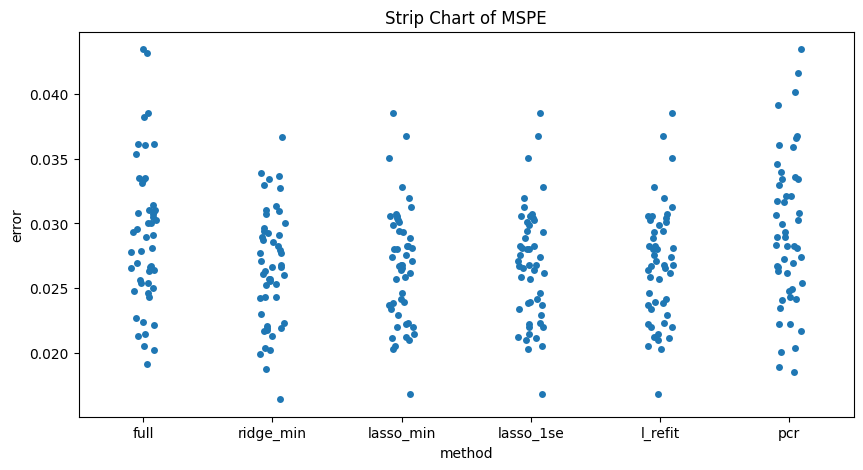

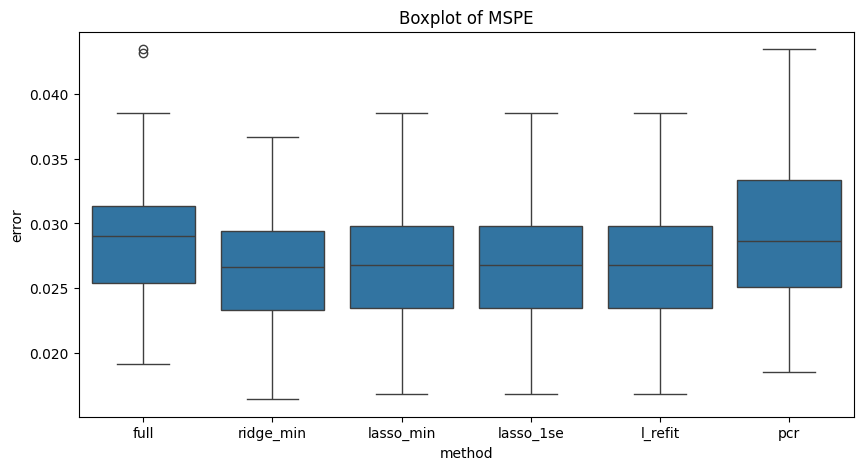

In [ ]:
# Converting dictionary to a pandas DataFrame for easier plotting
df = pd.DataFrame.from_dict(error_log, orient='index').transpose().melt(var_name='method', value_name='error')

# Strip chart (strip plot)
plt.figure(figsize=(10, 5))
sns.stripplot(x='method', y='error', data=df, jitter=True)
plt.title('Strip Chart of MSPE')
plt.show()

# Boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x='method', y='error', data=df)
plt.title('Boxplot of MSPE')
plt.show()

### [c] Answering the questions

1. Which procedure or procedures yield the best performance in terms of MSPE?

*Answer:* Based on the boxplot, **Ridge_min** appears to yield the best performance, as its MSPE values tend to be lower than in other procedures, with a slightly smaller median and a more compact distribution.

2. Conversely, which procedure or procedures show the poorest performance?

*Answer:* Looking at the boxplot, it seems like **PCR** shows the poorest performance, as it has the widest range of MSPE values and a higher median compared to the other procedures.

3. In the context of Lasso regression, which procedure, Lasso.min or Lasso.1se, yields a better MSPE?

*Answer:* **Lasso.min** and **Lasso.1se** seem both to have similar MSPE distributions and ranges, indicating that their performance is nearly identical.

4. Is refitting advantageous in this case? In other words, does L.Refit outperform Lasso.1se?

*Answer:* **L.Refit** seems to have the same MSPE sitribtion and ranges as **Lasso.1se**, meaning L.Refit does not outperform Lasso.1se.

5. Is variable selection or shrinkage warranted for this particular dataset? To clarify, do you find the performance of the Full model to be comparable to, or divergent from, the best-performing procedure among the other five?

*Answer:* **Full** model has larger range of MSPE and a higher median compared to the best-performing shrinkage method, **Ridge.min**.

## Case 2

### Reading Coding2_Data2.csv

In [ ]:
myData2 = pd.read_csv("datasets/Coding2_Data2.csv")
myData2.head()

,Y,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,N491,N492,N493,N494,N495,N496,N497,N498,N499,N500
0,3.178054,-5.064036,1.8,0.837248,0,-0.619897,1.883275,3.432567,1.408545,0.000000,...,9.311734,42.340409,-98.237024,-0.218876,242.378197,22.914414,2.833203,-0.731567,188.338755,5.603043
1,3.072693,-3.600502,0.0,1.955860,0,-0.757153,1.859574,5.529585,1.602836,0.693147,...,2.483401,42.541682,-78.161235,0.006359,230.500638,21.378003,7.343570,-0.772128,54.120184,12.177419
2,3.546740,-3.601235,0.0,1.955860,0,-0.757153,1.971996,2.918119,1.602836,0.693147,...,2.194146,42.293921,-147.972805,-0.090360,242.084995,21.058327,3.806554,-1.270361,44.435169,9.204234
3,3.508556,-3.430523,0.0,0.779325,0,-0.780886,1.945624,1.419592,1.802073,1.098612,...,1.380064,42.239553,-98.077415,-0.123421,238.506944,22.806647,2.727724,-0.899344,25.356220,4.598476
4,3.589059,-2.672924,0.0,0.779325,0,-0.780886,1.966693,2.162710,1.802073,1.098612,...,5.271136,42.241969,-114.842999,0.213375,228.014166,21.363451,1.084881,-1.203496,135.781350,1.796305


In [ ]:
Y = myData2['Y']
X = myData2.drop(['Y'], axis = 1)
X.shape, len(Y)

((506, 591), 506)

###[a] Conducting simulation exercise

In [ ]:
keys = ['ridge_min', 'lasso_min', 'lasso_1se', 'l_refit', 'pcr']
error_log2 = {key: [] for key in keys}

for i in range(50):

  n = len(Y)
  indices = np.arange(0, n)
  np.random.shuffle(indices)
  test_ind = indices[:int(np.floor(0.25*n))]
  train_ind = indices[len(test_ind):]

  # Splitting the data into training and testing sets
  X_train = X.iloc[train_ind]
  Y_train = Y[train_ind]

  X_test = X.iloc[test_ind]
  Y_test = Y[test_ind]

  # 1. Ridge.min
  error = ridge_min(X_train, Y_train, X_test, Y_test)
  error_log2['ridge_min'].append(error)

  # 2. Lasso.min
  error = lasso(X_train, Y_train, X_test, Y_test, alpha_min=True)
  error_log2['lasso_min'].append(error)

  # 3. Lasso.1se
  error = lasso(X_train, Y_train, X_test, Y_test, alpha_1se=True)
  error_log2['lasso_1se'].append(error)

  # 4. L.Redit
  error = lasso(X_train, Y_train, X_test, Y_test, lrefit=True)
  error_log2['l_refit'].append(error)

  # 5. PCR
  error = pcr_model(X_train, Y_train, X_test, Y_test)
  error_log2['pcr'].append(error)


### [b] Graphically summarizing the results

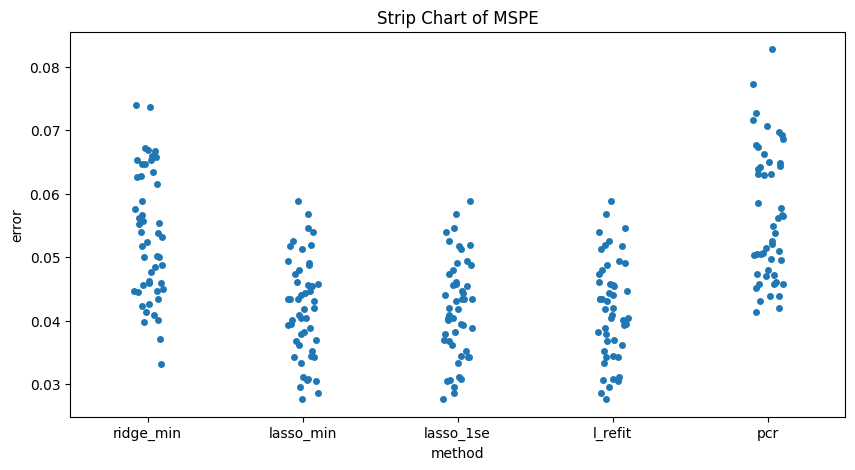

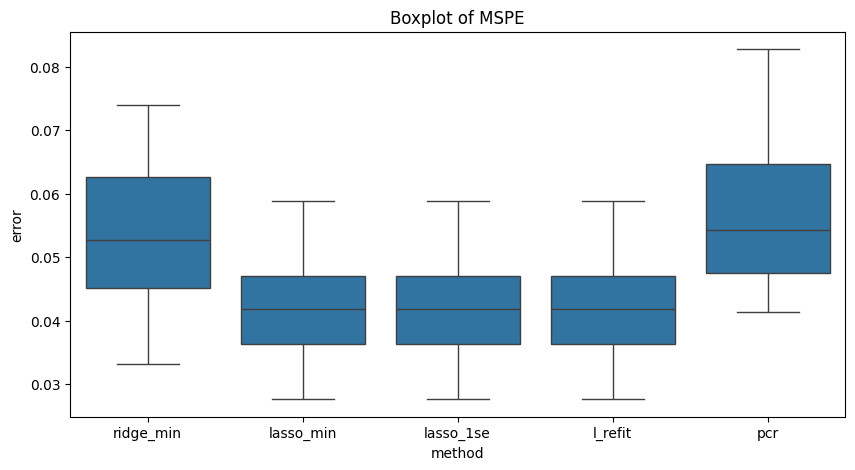

In [ ]:
# Converting dictionary to a pandas DataFrame for easier plotting
df2 = pd.DataFrame.from_dict(error_log2, orient='index').transpose().melt(var_name='method', value_name='error')

# Strip chart (strip plot)
plt.figure(figsize=(10, 5))
sns.stripplot(x='method', y='error', data=df2, jitter=True)
plt.title('Strip Chart of MSPE')
plt.show()

# Boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x='method', y='error', data=df2)
plt.title('Boxplot of MSPE')
plt.show()

### [c] Answering the questions

1. Which procedure or procedures yield the best performance in terms of MSPE?

*Answer:* From the boxplot, **Lasso.min**, **Lasso.1se** and **L.Refit** procedures seem to have the same best performance in terms of MSPE because they have lower median values.



2. Conversely, which procedure or procedures show the poorest performance?

*Answer:* From the boxplot, poorest performance corresponds to **PCR** because it has the highest median.



3. Have you observed any procedure or procedures that performed well in Case I but exhibited poorer
performance in Case II, or vice versa? If so, please offer an explanation.

*Answer:* In Case I, **Ridge.min** demonstrated the best performance, but in Case II, its performance declined in terms of MSPE. This is probably because Ridge Regression does not remove any columns, meaning Noise was still present in the model. The other procedures performed similarly across both cases — **Lasso_min**, **Lasso_1se**, and **L.Refit** consistently delivered strong results, whereas PCR continued to show poor performance.



4. Given that Coding2_Data2.csv includes all features found in Coding2_Data1.csv, one might anticipate that the best MSPE in Case II would be equal to or lower than the best MSPE in Case I. Do your simulation results corroborate this expectation? If not, please offer an explanation.

*Answer:* In Case I, the best performance was achieved by **Ridge_min**, with an MSPE around 0.015. However, in Case II, the best performance was observed with **Lasso_min**, **Lasso_1se**, and **L.Refit**, with the lowest MSPE around 0.027. As we can see, the best MSPE in Case II is neither equal to nor lower than the best MSPE in Case I. This discrepancy could be caused by overfitting, as the addition of 500 artificially generated noise columns likely did not contribute to improving the model's performance and may have introduced irrelevant variability.